In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import joblib

In [25]:
# Step 1: Data Collection
data = pd.read_csv('/content/drive/MyDrive/int/spam_ham_dataset.csv')

In [26]:
# Step 2: Data Preprocessing

print("\nMissing Values:")
print(data.isnull().sum())
data = data.dropna()  # Drop rows with missing values

# Convert labels to numerical format
data['label_num'] = data['label'].apply(lambda x: 1 if x == 'spam' else 0)


Missing Values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


In [27]:
# Step 3: Split Data
X = data['text']
y = data['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### #Step 4:Model Selection
 Multinominal Naive bayes model is generally used for the text classification tasks whereas Logistic regression model is preferred for binary classification tasks.
Here we can decide the optimal model for this task based on the accuracy and precision, which shows us that
###Logistic regression model is the best model

In [28]:
# Step 5 & 6: Model Training and Evaluation

# Function to evaluate models
def evaluate_model(model, X_test_vec, y_test):
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f'\nModel: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:\n', cm)
    return y_pred

# 1. Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds = evaluate_model(nb_model, X_test_vec, y_test)

# 2. Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)
lr_preds = evaluate_model(lr_model, X_test_vec, y_test)

# 3. Support Vector Machine
svm_model = SVC(probability=True)  # Enable probability estimates for AUC-ROC
svm_model.fit(X_train_vec, y_train)
svm_preds = evaluate_model(svm_model, X_test_vec, y_test)

# 4. Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_vec, y_train)
rf_preds = evaluate_model(rf_model, X_test_vec, y_test)


Model: MultinomialNB
Accuracy: 0.9710
Precision: 0.9519
Recall: 0.9454
F1 Score: 0.9486
Confusion Matrix:
 [[728  14]
 [ 16 277]]

Model: LogisticRegression
Accuracy: 0.9855
Precision: 0.9633
Recall: 0.9863
F1 Score: 0.9747
Confusion Matrix:
 [[731  11]
 [  4 289]]

Model: SVC
Accuracy: 0.9623
Precision: 0.9045
Recall: 0.9693
F1 Score: 0.9357
Confusion Matrix:
 [[712  30]
 [  9 284]]

Model: RandomForestClassifier
Accuracy: 0.9749
Precision: 0.9435
Recall: 0.9693
F1 Score: 0.9562
Confusion Matrix:
 [[725  17]
 [  9 284]]


In [ ]:
# Step 7: Hyperparameter Tuning (Example with Random Forest)
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_vec, y_train)

print(f'Best parameters from grid search: {grid_search.best_params_}')
best_rf_model = grid_search.best_estimator_

# Evaluate the best model from grid search
evaluate_model(best_rf_model, X_test_vec, y_test)

Best parameters from grid search: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Model: RandomForestClassifier
Accuracy: 0.9778
Precision: 0.9412
Recall: 0.9829
F1 Score: 0.9616
Confusion Matrix:
 [[724  18]
 [  5 288]]


array([0, 1, 0, ..., 1, 0, 0])

AUC-ROC for MultinomialNB: 0.9929


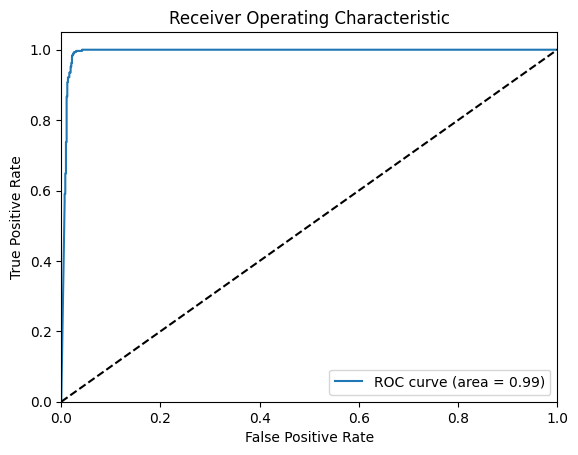

Text: Congratulations! You've won a free ticket to Bahamas. Click here to claim your prize.
Predicted: spam

Text: Hi, I hope you are doing well. Let’s catch up this weekend.
Predicted: ham

Text: Get paid for taking surveys online. Sign up now!
Predicted: ham

Text: Meeting scheduled for tomorrow at 10 AM. Please confirm your availability.
Predicted: ham

Text: Your account has been compromised. Please click the link to secure it.
Predicted: spam

Text: The free trail of your netflix account has expired, to continue your premium content renew the membership.
Predicted: spam



In [ ]:
# Step 8: AUC-ROC Evaluation for the best model
best_model = nb_model  # Change this to the best performing model from evaluation
y_probs = best_model.predict_proba(X_test_vec)[:, 1]  # Get predicted probabilities
auc = roc_auc_score(y_test, y_probs)
print(f'AUC-ROC for {best_model.__class__.__name__}: {auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Model Testing with Random Sample Emails
def test_model_on_sample_texts(model, vectorizer, sample_texts):
    # Transform the sample texts using the same vectorizer
    sample_texts_vec = vectorizer.transform(sample_texts)

    # Predict using the model
    predictions = model.predict(sample_texts_vec)

    # Convert predictions to labels
    predictions_labels = ['spam' if pred == 1 else 'ham' for pred in predictions]

    # Print the results
    for text, label in zip(sample_texts, predictions_labels):
        print(f'Text: {text}\nPredicted: {label}\n')

# Define some sample emails to test
sample_emails = [
    "Congratulations! You've won a free ticket to Bahamas. Click here to claim your prize.",
    "Hi, I hope you are doing well. Let’s catch up this weekend.",
    "Get paid for taking surveys online. Sign up now!",
    "Meeting scheduled for tomorrow at 10 AM. Please confirm your availability.",
    "Your account has been compromised. Please click the link to secure it.",
    "The free trail of your netflix account has expired, to continue your premium content renew the membership."
]

# Test the best model (you can replace this with any model you want to test)
test_model_on_sample_texts(best_model, vectorizer, sample_emails)

In [ ]:
# Step 9: Save the Models and Vectorizer for Deployment
joblib.dump(nb_model, 'spam_classifier_nb.pkl')
joblib.dump(lr_model, 'spam_classifier_lr.pkl')
joblib.dump(svm_model, 'spam_classifier_svm.pkl')
joblib.dump(best_rf_model, 'spam_classifier_rf.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# To load and use the models later:
# model = joblib.load('spam_classifier_nb.pkl')  # For Naive Bayes
# model = joblib.load('spam_classifier_lr.pkl')  # For Logistic Regression
# model = joblib.load('spam_classifier_svm.pkl')  # For SVM
# model = joblib.load('spam_classifier_rf.pkl')   # For Random Forest


['vectorizer.pkl']